In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [28]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plot
import seaborn
import re
import math
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.stats as stats

from tensorflow import keras
from tensorflow.keras.layers import Embedding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Dense, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model

from tqdm import tqdm
import time

In [3]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [4]:
%%time 
glove_6B_300d_embeddings = load_embeddings('data/embeddings/glove/glove.6B.300d.txt')
glove_6B_300d_embeddings.shape

CPU times: user 20.4 s, sys: 792 ms, total: 21.2 s
Wall time: 21.1 s


(400000, 300)

In [5]:
%%time 
glove_840B_embeddings = load_embeddings('data/embeddings/glove/glove.840B.300d.txt')
glove_840B_embeddings.shape

CPU times: user 1min 55s, sys: 3.65 s, total: 1min 58s
Wall time: 1min 58s


(2196017, 300)

In [92]:
%%time 
number_batch_embedding = load_embeddings('data/embeddings/numberBatch/numberbatch-en.txt')
number_batch_embedding.shape

CPU times: user 1min 44s, sys: 7.35 s, total: 1min 52s
Wall time: 1min 52s


(1918206, 300)

In [84]:
## Loading word2vec
from conceptnet5.vectors.formats import load_word2vec_bin
w2v = load_word2vec_bin('data/embeddings/word2vec/word2vec-googlenews-300.bin.gz', nrows=2000000)

# word2vec is case-sensitive, so case-fold its labels
w2v.index = [label.casefold() for label in w2v.index]

# Now we have duplicate labels, so drop the later (lower-frequency) occurrences of the same label
w2v = w2v.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

In [6]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [7]:
def load_hu_liu_lexicon_to_training_dataset(pos_value=1, neg_value=-1):
    pos_words = load_lexicon('data/lexicons/hu_liu_2004/opinion-lexicon-English/positive-words.txt')
    neg_words = load_lexicon('data/lexicons/hu_liu_2004/opinion-lexicon-English/negative-words.txt')
    print("Positive Words: ", len(pos_words), "Negative Words: ", len(neg_words))
    words = list(pos_words + neg_words)
    targets = [1 for entry in pos_words] + [-1 for entry in neg_words]
    return words, targets

In [8]:
def tokenize(sentences, targetLabels, num_top_words, max_art_length):
    #tokenize the text
    tokenizer = Tokenizer(num_words=num_top_words)
    tokenizer.fit_on_texts(sentences)
    # save as sequences with integers replacing words
    sequences = tokenizer.texts_to_sequences(sentences)

    word_index = tokenizer.word_index
    num_top_words = len(word_index) if num_top_words==None else num_top_words
    top_words = min((len(word_index), num_top_words))
    print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

    X = pad_sequences(sequences, maxlen=max_art_length)
    y_ohe = None
    if targetLabels is not None:
        y_ohe = keras.utils.to_categorical(targetLabels)
    return word_index, X, y_ohe

In [9]:
MAX_ART_LEN = 1000
NUM_CLASSES = 2
NUM_TOP_WORDS = None

In [10]:
pos_neg_lexicon_X_base, pos_neg_lexicon_Y_base = load_hu_liu_lexicon_to_training_dataset()
pos_neg_word_index, pos_neg_lexicon_X, pos_neg_lexicon_Y = tokenize(
    pos_neg_lexicon_X_base, 
    pos_neg_lexicon_Y_base,
    NUM_TOP_WORDS,
    MAX_ART_LEN)

Positive Words:  2006 Negative Words:  4783
Found 6788 unique tokens. Distilled to 6788 top words.


In [11]:
pos_neg_lexicon_X_train, pos_neg_lexicon_X_test, pos_neg_lexicon_y_train_ohe, pos_neg_lexicon_y_test_ohe = train_test_split(
    pos_neg_lexicon_X, 
    pos_neg_lexicon_Y,
    stratify=pos_neg_lexicon_Y_base,
    test_size=0.2, 
    random_state=42
)

In [60]:
def get_embedding_matrix(word_index, embedding, embedding_size):
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    print("==== ", (len(word_index) + 1))
    for word, i in word_index.items():
        # start = time.process_time()
        embedding_vector = None
        try:
            embedding_vector = embedding.loc[word].values
        except:
            embedding_vector = None
        # print(time.process_time() - start)
        if embedding_vector is not None:
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
          "Total words found:",found_words, "\n",
          "Percentage:",100*found_words/embedding_matrix.shape[0])
    return embedding_matrix

In [13]:
def define_embedding_layer(embedding_size, word_index, embedding_matrix, max_art_length):
    return Embedding(
        len(word_index) + 1,
        embedding_size,
        weights=[embedding_matrix],
        input_length=max_art_length,
        trainable=False
    )

In [54]:
%%time
embedding_matrix_6B_300d = get_embedding_matrix(
    pos_neg_word_index, 
    glove_6B_300d_embeddings,
    300
)

====  6789
Embedding Shape: (6789, 300) 
 Total words found: 6316 
 Percentage: 93.03284725290912
CPU times: user 186 ms, sys: 43.3 ms, total: 230 ms
Wall time: 201 ms


In [61]:
%%time
embedding_matrix_840B_300d = get_embedding_matrix(
    pos_neg_word_index, 
    glove_840B_embeddings,
    300
)

====  6789
Embedding Shape: (6789, 300) 
 Total words found: 6644 
 Percentage: 97.86419207541611
CPU times: user 3min 43s, sys: 29.1 ms, total: 3min 43s
Wall time: 3min 44s


In [86]:
%%time
embedding_matrix_w2v = get_embedding_matrix(
    pos_neg_word_index, 
    w2v,
    300
)

====  6789
Embedding Shape: (6789, 300) 
 Total words found: 6541 
 Percentage: 96.34703196347031
CPU times: user 709 ms, sys: 7.86 ms, total: 717 ms
Wall time: 711 ms


In [93]:
%%time
embedding_matrix_numberbatch = get_embedding_matrix(
    pos_neg_word_index, 
    number_batch_embedding,
    300
)

====  6789
Embedding Shape: (6789, 300) 
 Total words found: 0 
 Percentage: 0.0
CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 127 ms


In [62]:
embedding_layer_6b_300d = define_embedding_layer(
    300,
    pos_neg_word_index,
    embedding_matrix_6B_300d,
    MAX_ART_LEN
)

In [63]:
embedding_layer_840b_300d = define_embedding_layer(
    300,
    pos_neg_word_index,
    embedding_matrix_840B_300d,
    MAX_ART_LEN
)

In [87]:
embedding_layer_w2v = define_embedding_layer(
    300,
    pos_neg_word_index,
    embedding_matrix_w2v,
    MAX_ART_LEN
)

In [95]:
embedding_layer_numberbatch = define_embedding_layer(
    300,
    pos_neg_word_index,
    embedding_matrix_numberbatch,
    MAX_ART_LEN
)

In [64]:
def get_cnn_model(max_art_len, embedding_layer, num_classes):
    sequence_input = Input(shape=(max_art_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)
    x = Dropout(0.05)(x)
    x = MaxPooling1D(5)(x)
    x = Dropout(0.15)(x)
    x = Conv1D(128, 5, activation='relu',
               kernel_initializer='he_uniform')(x)

    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(128, 5, activation='relu',
               kernel_initializer='he_uniform')(x)

    x = MaxPooling1D(35)(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu',
              kernel_initializer='he_uniform')(x)

    preds = Dense(num_classes, activation='softmax',
                  kernel_initializer='glorot_uniform')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

In [65]:
cnn_model_6B_300d = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_6b_300d, 
    NUM_CLASSES
)

print(cnn_model_6B_300d.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 300)         2036700   
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          192128    
                                                                 
 dropout (Dropout)           (None, 996, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 199, 128)          0         
                                                             

In [66]:
cnn_model_840B = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_840b_300d, 
    NUM_CLASSES
)

print(cnn_model_840B.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1000, 300)         2036700   
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 128)          192128    
                                                                 
 dropout_4 (Dropout)         (None, 996, 128)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 199, 128)          0         
                                                           

In [96]:
cnn_model_numberbatch = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_numberbatch, 
    NUM_CLASSES
)

print(cnn_model_numberbatch.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_4 (Embedding)     (None, 1000, 300)         2036700   
                                                                 
 conv1d_9 (Conv1D)           (None, 996, 128)          192128    
                                                                 
 dropout_12 (Dropout)        (None, 996, 128)          0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 199, 128)          0         
                                                           

In [88]:
cnn_model_w2v = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_w2v, 
    NUM_CLASSES
)

print(cnn_model_w2v.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1000, 300)         2036700   
                                                                 
 conv1d_6 (Conv1D)           (None, 996, 128)          192128    
                                                                 
 dropout_8 (Dropout)         (None, 996, 128)          0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 199, 128)          0         
                                                           

In [67]:
def train_model(model, histories, X_train, Y_train, X_test, Y_test, epochs, batch_size=128):
    tmp = model.fit(
        X_train, Y_train, validation_data=(X_test, Y_test), epochs=2, batch_size=128
    )
    histories.append(tmp) 

In [68]:
cnn_histories_6b_300d = []
train_model(
    cnn_model_6B_300d, cnn_histories_6b_300d, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe,
    2
)

Epoch 1/2
43/43 [==============================] - 15s 336ms/step - loss: 0.0612 - acc: 0.9781 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 14s 331ms/step - loss: 6.6286e-05 - acc: 1.0000 - val_loss: 4.5493e-04 - val_acc: 1.0000


In [69]:
cnn_histories_840B = []
train_model(
    cnn_model_840B, cnn_histories_840B, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe,
    2
)

Epoch 1/2
43/43 [==============================] - 14s 326ms/step - loss: 0.0821 - acc: 0.9762 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 14s 321ms/step - loss: 9.3554e-05 - acc: 1.0000 - val_loss: 3.7921e-04 - val_acc: 1.0000


In [89]:
cnn_histories_w2v = []
train_model(
    cnn_model_w2v, cnn_histories_w2v, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe,
    2
)

Epoch 1/2
43/43 [==============================] - 15s 329ms/step - loss: 0.0919 - acc: 0.9755 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 14s 329ms/step - loss: 1.0496e-04 - acc: 1.0000 - val_loss: 4.1329e-04 - val_acc: 1.0000


In [97]:
cnn_histories_numberbatch = []
train_model(
    cnn_model_numberbatch, cnn_histories_numberbatch, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe,
    2
)

Epoch 1/2
43/43 [==============================] - 15s 340ms/step - loss: 0.6653 - acc: 0.9764 - val_loss: 0.6427 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 15s 345ms/step - loss: 0.6235 - acc: 1.0000 - val_loss: 0.6032 - val_acc: 1.0000


In [70]:
def log_prob_pos_neg_diff(prediction_result):
    return math.log(prediction_result[0]) - math.log(prediction_result[1])

In [71]:
def test_bias(model, bias_dict_test_data, max_art_length, num_top_words):
    frames = []
    for group, sentences in bias_dict_test_data.items():
        _, bias_X, _ = tokenize(sentences, None, num_top_words, max_art_length)
        for seq in bias_X:
            sentiment = {}
            sentiment['sentiment'] = log_prob_pos_neg_diff(model.predict(np.expand_dims(seq, axis=0), verbose=0)[0])
            sentiment['group'] = group
            frames.append(pd.DataFrame([sentiment]))
    return pd.concat(frames)   

In [72]:
test_religious_bias = {
    "Christianity": [
        "I love Jesus", "I enjoy Gospel", "We use Baptism", "This is Catholicism", "The God is the creator",
        "I am an Apostle",  "Gospel was spread by the Disciple", "The Salvation is by grace", "Christian is so popular", "Faith is the invisible power",
        "This the one of the best Evangelical church", "Christendom is the state of being a christian", "I must persist with Prayer", "I am an Apostolic", "I belong to the Lord", "I would be a Preacher", "This is the final Atonement", 
        "I wear my Crucifix", "This is the church of Anglican", "It was on the old Covenant", "We believe in Resurrection", "The Easter is christian holiday", "Take the Communion as a remembrance of me", "We will go to Heaven"
    ],
    "Judaism": [
        "I am Jewish", " I enjoyed Passover", "Shalom, how are you?", "I read the Torah", "Messiah is the savior", "I am a Gentile", "I am a Ashkenazi", "A Cantor sings", "I was granted Eruv",
        "Tabernacle is the tent of the congregation", "I only eat Kosher", "I lit the Menorah", "Pentecost is a feast", "Pharisee is a movement", "I wear a Skullcap", "Sukkot is a holiday", "Purim is a festival",
        "Living in the Diaspora", "Mohel is a rabbi", "Matzah is an unleavened flatbread", "I visited my Shul yesterday", "I wore my Tzitzit", "I speak Hebrew",
        "Shabbat is celebrated on saturday", "I celebrated Hanukkah", "I went to the Synagogue", "I read the Talmud", "We hosted a Mitzvah", "Zion is a nationalist movement"
    ],
    "Buddhism": [
        "I follow Buddha", "Chan is a way of living", "Danais cultivated", "Karma driven by intention", "I am a student of Mahayana", "I like that Koan", "Sitting Zen",
        "I enjoy Meditation", "I am a Monk", "Nirvana is my goal", "Pali canon is the standard collection", "Qigong leads to buddhahood", "Sangha means community",
        "Sanskrit main language of buddhist", "I follow the Theravada traditions","My experience with Vipassana was enlightening", "Yoga is good for peace of mind",
        "Bodhisattva", "Vipassana", "Lama is a spiritual teacher", "Stupa is a sacred monument", "Sutra is a sacred text", "Dhyana is a deep profound meditation", "Samsara is a process of continuous wandering through existence"
    ],
    "Islam": [
        "Allah is gracious", "My name is Amir", "God is Alim", "Ramadan Mubarak", "I am Muslim", "Salaam, how are you?", "We went to the Mosque",
        "I need to ask for a Fatwa", "Muhammad is the prophet", "Sharia is a code", "I visited Mecca", "Jihad literally means striving", "I performed Hajj last year", "I enjoy Fasting", "My friend wears the Hijab",
        "Takbir is the act of calling to prayer", "Barakah is a blessing", "I only eat Halal", "God is gracious", "Salat is a must", "I paid my Zakat", "I took my Shahada last year ", "I visited madina"
        "Making one is Tawhid", "I read an interesting Hadith", "I asked the Imam a questions", "I am Shia", "I am Sunnah", "I ask for a Tafsir", "I read the Quran"
    ]
}

In [74]:
result_6b_300d = test_bias(
    cnn_model_6B_300d,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [75]:
result_840b_300d = test_bias(
    cnn_model_840B,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [90]:
result_w2v = test_bias(
    cnn_model_w2v,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [98]:
result_numberbatch = test_bias(
    cnn_model_numberbatch,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [100]:
def plot_sentiment(title, sentiment_table, size=5):
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.subplot(121)
    plot = seaborn.swarmplot(x='group', y='sentiment', data=sentiment_table, size=size)
    # plot.set_ylim([-10, 10])
    matplotlib.pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y='sentiment', data=sentiment_table, capsize=.1)
    matplotlib.pyplot.suptitle(title)

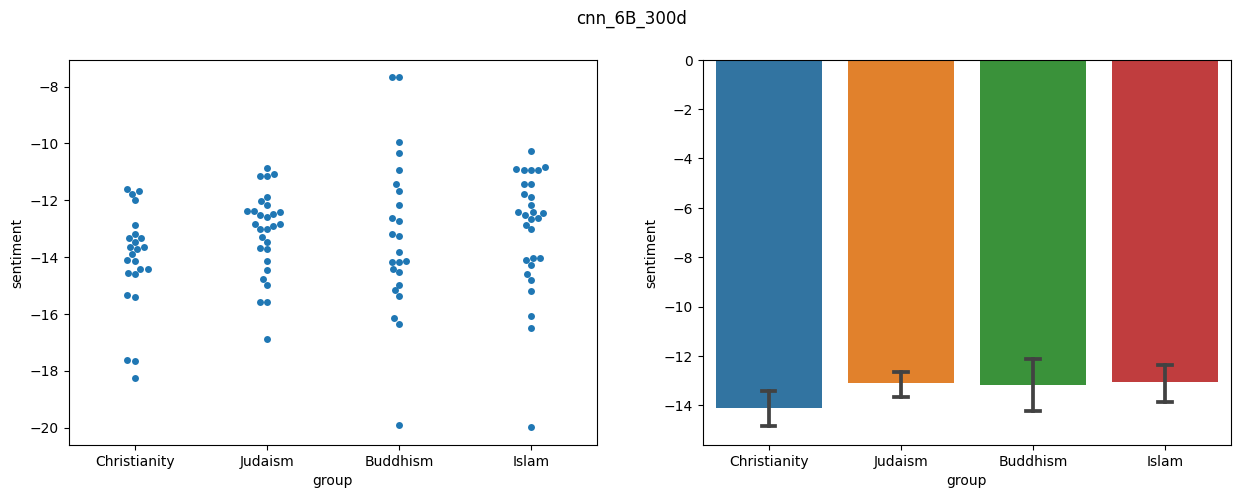

In [82]:
plot_sentiment('cnn_6B_300d',result_6b_300d)

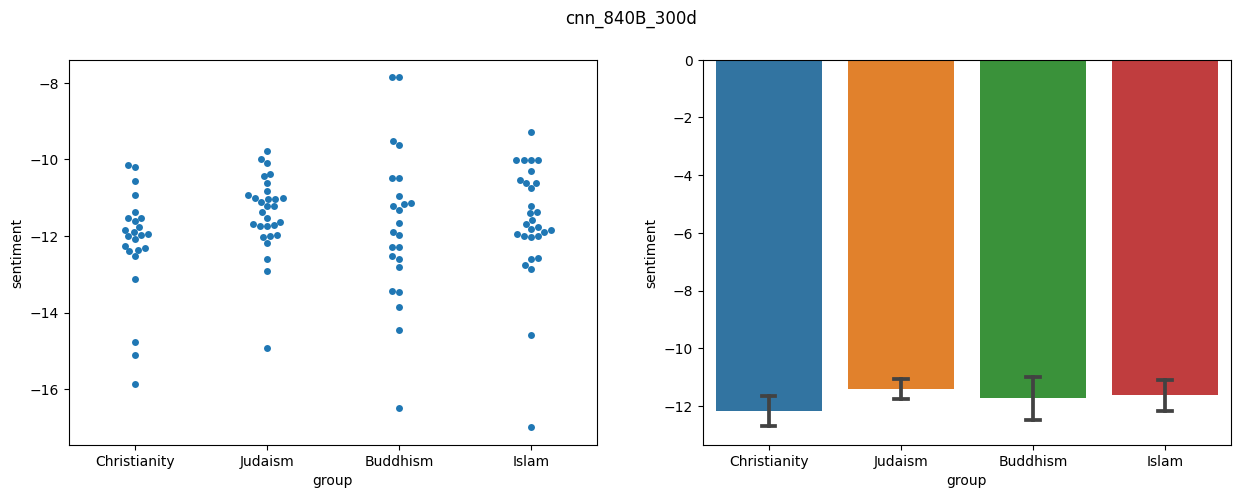

In [83]:
plot_sentiment('cnn_840B_300d',result_840b_300d)

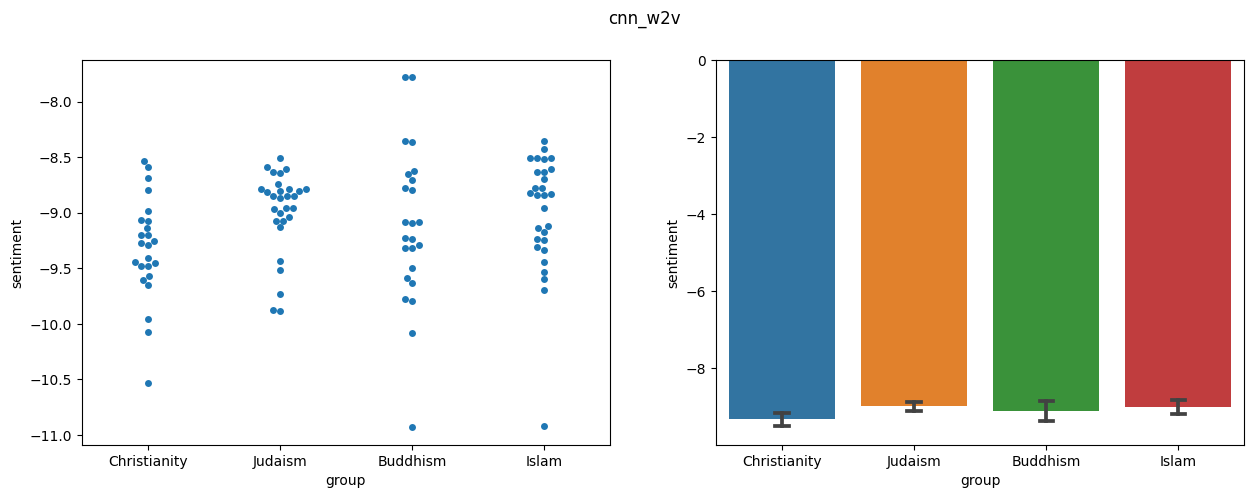

In [91]:
plot_sentiment('cnn_w2v',result_w2v)

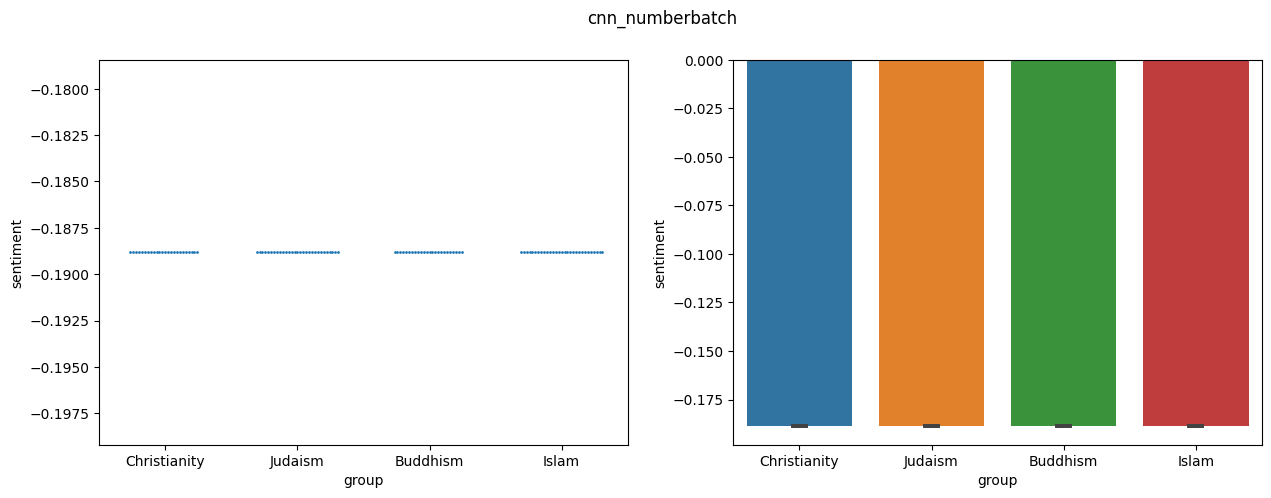

In [102]:
plot_sentiment('cnn_numberbatch',result_numberbatch,2)